In [1]:
!nvidia-smi

Mon Nov 15 22:43:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:01:00.0 Off |                  N/A |
| 23%   26C    P8     8W / 250W |    124MiB / 11177MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:02:00.0 Off |                  N/A |
| 27%   

In [1]:
%%time

import os
import numpy as np
import torch
import random
import pytorch_lightning as pl
import cv2
import json

from PIL import Image
from torchvision import transforms
from typing import Dict

from tqdm.notebook import tqdm

import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from torchvision.transforms import Compose, Lambda
from torchvision.transforms._transforms_video import CenterCropVideo, NormalizeVideo

from pytorchvideo.data.encoded_video import EncodedVideo
from pytorchvideo.transforms import ApplyTransformToKey, ShortSideScale, UniformTemporalSubsample, UniformCropVideo

import matplotlib.pyplot as plt
%matplotlib inline

from CPD import datasets, loss, models
from CPD import new_metrics as metrics

CPU times: user 1.42 s, sys: 384 ms, total: 1.8 s
Wall time: 1.58 s


### Fix GPU

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

### Fix random seeds

In [3]:
import torch
torch.manual_seed(1)
import random
random.seed(1)
import numpy as np
np.random.seed(1)

### Device

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Dataloader

In [5]:
class UCF_VIDEOS_DATASET(torch.utils.data.Dataset):
    def __init__(self, path_to_annotation, path_to_videos, seq_len):
        super(UCF_VIDEOS_DATASET, self).__init__()
        self.path_to_annotation = path_to_annotation
        self.path_to_videos = path_to_videos
        self.seq_len = seq_len
        
        self.annotation_array = []
        
        preprocess = transforms.Compose([transforms.ToTensor()])
        
        time_step = 3
        num_samles = 6
        num_attempts = 300
        
        self.data = []
        self.len = 0
        
        with open(path_to_annotation, 'r') as fp:
            for line in tqdm(fp):
                if line.split("  ")[1] == "Explosion":
                    self.annotation_array.append([line.split("  ")[0], 
                                                  int(line.split("  ")[2]), 
                                                  int(line.split("  ")[3]),
                                                  int(line.split("  ")[4])])
                    
                    cap = cv2.VideoCapture(os.path.join(self.path_to_videos, line.split("  ")[0]))
                    
                    count_ = 0
                    num_attempts_ = 0
                    nums_zeros = []
                    while count_ != num_samles:
                        num_attempts_ += 1
                        num_zeros = random.randint(1, self.seq_len-1)
                        if not num_zeros in nums_zeros:
                            frames_ones = [int(line.split("  ")[3]) + i*time_step for i in range(self.seq_len-num_zeros)]
                            frames_zeros = sorted([int(line.split("  ")[3]) - (i+1)*time_step for i in range(num_zeros)])
                            
                            if frames_zeros[0] >= int(line.split("  ")[2]) and frames_ones[-1] <= int(line.split("  ")[4]):
                                frames_all = np.append(frames_zeros, frames_ones)
                                sequence_labels = np.append(np.zeros(num_zeros), np.ones(self.seq_len-num_zeros))
                                sequence_imgs = []

                                for frame_id in frames_all:
                                    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
                                    ret, frame = cap.read()
                                    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                                    frame_pil = Image.fromarray(frame_rgb)
                                    sequence_imgs.append(preprocess(frame_pil))

                                sequence_imgs = torch.stack(sequence_imgs)
                                sequence_labels = torch.from_numpy(sequence_labels)
                                self.data.append([sequence_imgs, sequence_labels])

                                count_ += 1
                                nums_zeros.append(num_zeros)
                                self.len += 1
                            
                        if num_attempts_ == num_attempts:
                            break
                            
                if line.split("  ")[1] == "Normal":
                    self.annotation_array.append([line.split("  ")[0], 
                                                  int(line.split("  ")[2]), 
                                                  int(line.split("  ")[4])])
                    
                    cap = cv2.VideoCapture(os.path.join(self.path_to_videos, line.split("  ")[0]))
                    
                    num_zeros = self.seq_len
                    frames_all = sorted([int(line.split("  ")[4]) - i*time_step for i in range(num_zeros)])

                    if frames_zeros[0] >= int(line.split("  ")[2]):
                        sequence_labels = np.zeros(num_zeros)
                        sequence_imgs = []

                        for frame_id in frames_all:
                            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
                            ret, frame = cap.read()
                            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                            frame_pil = Image.fromarray(frame_rgb)
                            sequence_imgs.append(preprocess(frame_pil))

                        sequence_imgs = torch.stack(sequence_imgs)
                        sequence_labels = torch.from_numpy(sequence_labels)
                        self.data.append([sequence_imgs, sequence_labels])
                        self.len += 1
                        
                    frames_all = sorted([int(line.split("  ")[2]) + i*time_step for i in range(num_zeros)])

                    if frames_zeros[-1] <= int(line.split("  ")[5]):
                        sequence_labels = np.zeros(num_zeros)
                        sequence_imgs = []

                        for frame_id in frames_all:
                            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
                            ret, frame = cap.read()
                            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                            frame_pil = Image.fromarray(frame_rgb)
                            sequence_imgs.append(preprocess(frame_pil))

                        sequence_imgs = torch.stack(sequence_imgs)
                        sequence_labels = torch.from_numpy(sequence_labels)
                        self.data.append([sequence_imgs, sequence_labels])
                        self.len += 1

    def __len__(self):
        return self.len
        
    def __getitem__(self, item_idx):
        
        sequence_imgs = self.data[item_idx][0]
        sequence_labels = self.data[item_idx][1]
        
        return sequence_imgs, sequence_labels

In [6]:
%%time

seq_len = 16
path_to_videos = "data/explosion/"
path_annotation_train = "UCF_train.txt"
path_annotation_validation = "UCF_validation.txt"

imgs_dataset_train = UCF_VIDEOS_DATASET(path_annotation_train, 
                                        path_to_videos, 
                                        seq_len=seq_len)

imgs_dataset_validation = UCF_VIDEOS_DATASET(path_annotation_validation, 
                                             path_to_videos, 
                                             seq_len=seq_len)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

CPU times: user 46min 35s, sys: 6.85 s, total: 46min 42s
Wall time: 14min 4s


In [8]:
#HIDDEN_LSTM = 16
#HIDDEN_LSTM = 2048 * 7 * 7
HIDDEN_LSTM = 2048 * 8 * 10
HIDDEN_SIZE = 64

class Combine(nn.Module):
    def __init__(self):
        super(Combine, self).__init__()
        # Pick a pretrained model and load the pretrained weights
        model_name = "slow_r50"
        self.extractor = torch.hub.load('facebookresearch/pytorchvideo:main', 'slow_r50', pretrained=True)
        # 5 for full cnn part
        self.extractor = nn.Sequential(*list(self.extractor.blocks[:5]))
        self.fc1 = nn.Linear(HIDDEN_LSTM, HIDDEN_SIZE)
        self.rnn = nn.LSTM(input_size=HIDDEN_SIZE,
                           hidden_size=HIDDEN_SIZE // 2, 
                           num_layers=1,
                           batch_first=True, 
                           dropout=0.5)
        
        self.fc2 = nn.Linear(HIDDEN_SIZE // 2, 1)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()  
        self.activation = nn.Sigmoid()        

    def forward(self, x):
        
        batch_size, timesteps, C, H, W = x.size()
        c_in = x.transpose(1, 2) 
        c_out = self.extractor(c_in) # batch_size, timesteps, C*H*W
        r_in = c_out.transpose(1, 2).flatten(2)
        r_out = r_in
        r_out = self.fc1(r_out)
        r_out, _ = self.rnn(r_out)
        r_out = self.dropout(self.fc2(r_out))
        out = torch.sigmoid(r_out)
        return out    

### 

### Pytorch Lightning

In [9]:
class CPD_model(pl.LightningModule):
    def __init__(
        self,
        model, 
        imgs_dataset_train,
        imgs_dataset_validation,
        batch_size: int = 16,
        seq_len: int = 16, 
        loss_type: str = 'bce',
        path_to_videos: str = "data/explosion/",
        path_annotation_train: str = "UCF_train.txt",
        path_annotation_validation: str = "UCF_validation.txt",
        
    ):
        super(CPD_model, self).__init__()

        self.model = model.to(self.device)
        self.batch_size = batch_size
        self.seq_len = seq_len
        
        if loss_type == 'bce':
            self.loss = nn.BCELoss()
        else:
            self.loss = loss.CPDLoss(len_segment=8)
            
        self.imgs_dataset_train = imgs_dataset_train
        self.imgs_dataset_validation = imgs_dataset_validation   
        
    def forward(self, inputs):
        return self.model(inputs)

    def training_step(self, batch, batch_idx):
        videos, labels = batch
        pred = self.forward(videos.float())

        train_loss = self.loss(pred.squeeze(), labels.float().squeeze())
        train_accuracy = ((pred.squeeze() > 0.5).long() == labels.squeeze()).float().mean()

        self.log('train_loss', train_loss, prog_bar=True, on_epoch=True)
        self.log('train_acc', train_accuracy, prog_bar=True, on_epoch=True)    
        
        return train_loss

    def validation_step(self, batch, batch_idx):
        videos, labels = batch
        pred = self.forward(videos.float())
        
        val_loss = self.loss(pred.squeeze(), labels.float().squeeze())      
        val_accuracy = ((pred.squeeze() > 0.5).long() == labels.squeeze()).float().mean()
                
        self.log('val_loss', val_loss, prog_bar=True)    
        self.log('val_acc', val_accuracy, prog_bar=True)    
        
        return {'val_loss': val_loss, 'val_acc': val_accuracy}
    

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.model.parameters(), lr=0.001) 
        return [opt]

    def train_dataloader(self):
        
        train_dataloader = DataLoader(self.imgs_dataset_train, batch_size=self.batch_size, shuffle=True, num_workers=4)
        return train_dataloader
        
    
    def val_dataloader(self):
        
        val_dataloader = DataLoader(self.imgs_dataset_validation, batch_size=self.batch_size, shuffle=False, num_workers=4)
        return val_dataloader

## Model CUSTOM loss

In [10]:
model_custom = Combine()

for param in model_custom.extractor.parameters():
    param.requires_grad = False

model_custom_pl = CPD_model(model=model_custom,
                            imgs_dataset_train=imgs_dataset_train,
                            imgs_dataset_validation=imgs_dataset_validation,
                            batch_size=16, 
                            seq_len=16, 
                            loss_type='custom')    



running = 2

experiment_name = 'I3D_v{}'.format(running)
logger = pl.loggers.TensorBoardLogger(save_dir='logs/', name=experiment_name)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_acc',
    dirpath=f'logs/{experiment_name}',
    filename='{epoch:02d}-{val_acc:.3f}',
    mode='max')

checkpoint_callback_2 = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    dirpath=f'logs/{experiment_name}',
    filename='{epoch:02d}-{val_loss:.3f}',
    mode='min')


early_stop_callback = EarlyStopping(
   monitor='val_loss',
   min_delta=0.01,
   patience=5,
   verbose=True,
   mode='min'
)

trainer_custom = pl.Trainer(
    max_epochs=200, 
    gpus='0', 
    benchmark=True, 
    check_val_every_n_epoch=1, 
    logger=logger,
    callbacks=[checkpoint_callback, checkpoint_callback_2, early_stop_callback])    

Using cache found in /home/eromanenkova/.cache/torch/hub/facebookresearch_pytorchvideo_main
/home/eromanenkova/anaconda3/lib/python3.7/site-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [11]:
%%time

trainer_custom.fit(model_custom_pl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type    | Params
----------------------------------
0 | model | Combine | 42.1 M
1 | loss  | CPDLoss | 0     
----------------------------------
10.5 M    Trainable params
31.6 M    Non-trainable params
42.1 M    Total params
168.532   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.826


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.135 >= min_delta = 0.01. New best score: 0.691


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.546 >= min_delta = 0.01. New best score: 0.145


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.533 >= min_delta = 0.01. New best score: -0.388


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.721 >= min_delta = 0.01. New best score: -1.108


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.327 >= min_delta = 0.01. New best score: -1.435


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.130 >= min_delta = 0.01. New best score: -1.564


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.596 >= min_delta = 0.01. New best score: -2.161


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.815 >= min_delta = 0.01. New best score: -2.975


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.511 >= min_delta = 0.01. New best score: -3.487


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.108 >= min_delta = 0.01. New best score: -3.595


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.082 >= min_delta = 0.01. New best score: -3.677


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.603 >= min_delta = 0.01. New best score: -4.280


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.172 >= min_delta = 0.01. New best score: -4.452


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.390 >= min_delta = 0.01. New best score: -4.842


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 5 records. Best score: -4.842. Signaling Trainer to stop.


CPU times: user 9min 41s, sys: 2min 20s, total: 12min 1s
Wall time: 12min 22s


In [12]:
threshold_number = 25
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]

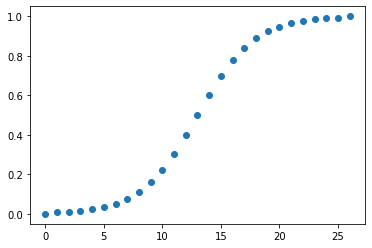

In [13]:
plt.plot(threshold_list, 'o')

In [14]:
_, delay_list_cpd, fp_delay_list_cpd = metrics.evaluation_pipeline(model_custom_pl, 
                                                                   model_custom_pl.val_dataloader(), 
                                                                   threshold_list, 
                                                                   device='cuda', 
                                                                   verbose=True)

/home/eromanenkova/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/eromanenkova/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


AUC: 10.712
Time to FA 13.8034, delay detection 1.5899 for best-cover threshold: 0.8411
TP 28, TN 102, FP 18, FN 30 for best-cover threshold: 0.8411
Max COVER 0.8591: for threshold 0.8411
Max F1 0.5385: for threshold 0.8411
F1 0.5385: for best-cover threshold 0.8411
Max F1_ruptures (M=5) 1.0: for threshold 0.9241
F1_ruptures 0.9524: for best-cover threshold 0.8411


In [15]:
np.save('delay_list_cpd.npy', delay_list_cpd)
np.save('fp_delay_list_cpd.npy', fp_delay_list_cpd)

### bce

In [22]:
model_bce = Combine()

for param in model_bce.extractor.parameters():
    param.requires_grad = False

model_bce_pl = CPD_model(model=model_custom,
                            imgs_dataset_train=imgs_dataset_train,
                            imgs_dataset_validation=imgs_dataset_validation,
                            batch_size=16, 
                            seq_len=16, 
                            loss_type='bce')

Using cache found in /home/eromanenkova/.cache/torch/hub/facebookresearch_pytorchvideo_main


In [17]:
experiment_name = 'I3D_v{}'.format(running)
logger = pl.loggers.TensorBoardLogger(save_dir='logs/', name=experiment_name)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_acc',
    dirpath=f'logs/{experiment_name}',
    filename='{epoch:02d}-{val_acc:.3f}',
    mode='max')

checkpoint_callback_2 = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    dirpath=f'logs/{experiment_name}',
    filename='{epoch:02d}-{val_loss:.3f}',
    mode='min')


early_stop_callback = EarlyStopping(
   monitor='val_loss',
   min_delta=0.01,
   patience=5,
   verbose=True,
   mode='min'
)

trainer_bce = pl.Trainer(
    max_epochs=200, 
    gpus='0', 
    benchmark=True, 
    check_val_every_n_epoch=1, 
    logger=logger,
    callbacks=[checkpoint_callback, checkpoint_callback_2, early_stop_callback])    

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [18]:
trainer_bce.fit(model_bce_pl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type    | Params
----------------------------------
0 | model | Combine | 42.1 M
1 | loss  | BCELoss | 0     
----------------------------------
10.5 M    Trainable params
31.6 M    Non-trainable params
42.1 M    Total params
168.532   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.341


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.052 >= min_delta = 0.01. New best score: 0.289


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.01. New best score: 0.279


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.279. Signaling Trainer to stop.


In [19]:
_, delay_list_bce, fp_delay_list_bce = metrics.evaluation_pipeline(model_bce_pl, 
                                                                   model_custom_pl.val_dataloader(), 
                                                                   threshold_list, 
                                                                   device='cuda', 
                                                                   verbose=True)

AUC: 9.61
Time to FA 11.9607, delay detection 0.7135 for best-cover threshold: 0.3029
TP 37, TN 93, FP 34, FN 14 for best-cover threshold: 0.3029
Max COVER 0.8653: for threshold 0.3029
Max F1 0.6387: for threshold 0.3973
F1 0.6066: for best-cover threshold 0.3029
Max F1_ruptures (M=5) 0.9412: for threshold 0.6971
F1_ruptures 0.7414: for best-cover threshold 0.3029


In [20]:
np.save('delay_list_bce.npy', delay_list_bce)
np.save('fp_delay_list_bce.npy', fp_delay_list_bce)

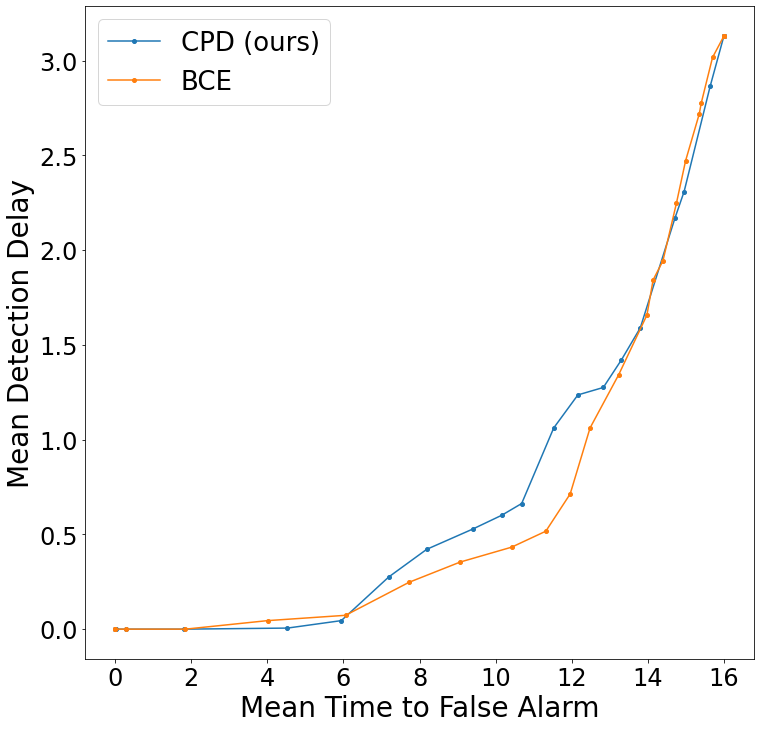

In [21]:
plt.figure(figsize=(12, 12))
plt.plot(fp_delay_list_cpd, delay_list_cpd, '-o', markersize=4, label='CPD (ours)')
plt.plot(fp_delay_list_bce, delay_list_bce, '-o', markersize=4, label='BCE')
#plt.plot(fp_delay_list_comb, delay_list_comb, '-o', markersize=4, label='Combined (ours)')

plt.xlabel('Mean Time to False Alarm', fontsize=28)
plt.ylabel('Mean Detection Delay', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(loc='upper left', fontsize=26);

### Combined

In [39]:
%%time

model_combined = Combine()

for param in model_combined.extractor.parameters():
    param.requires_grad = False

model_combined_pl_1 = CPD_model(model=model_combined,
                              imgs_dataset_train=imgs_dataset_train,
                              imgs_dataset_validation=imgs_dataset_validation,
                              batch_size=16, 
                              seq_len=16, 
                              loss_type='bce')

model_combined_pl_2 = CPD_model(model=model_combined,
                              imgs_dataset_train=imgs_dataset_train,
                              imgs_dataset_validation=imgs_dataset_validation,
                              batch_size=16, 
                              seq_len=16, 
                              loss_type='custom')



Using cache found in /home/eromanenkova/.cache/torch/hub/facebookresearch_pytorchvideo_main


CPU times: user 3.28 s, sys: 72 ms, total: 3.36 s
Wall time: 2.24 s


In [40]:
running = 2

experiment_name = 'I3D_v{}'.format(running)
logger = pl.loggers.TensorBoardLogger(save_dir='logs/', name=experiment_name)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_acc',
    dirpath=f'logs/{experiment_name}',
    filename='{epoch:02d}-{val_acc:.3f}',
    mode='max')

checkpoint_callback_2 = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    dirpath=f'logs/{experiment_name}',
    filename='{epoch:02d}-{val_loss:.3f}',
    mode='min')


early_stop_callback = EarlyStopping(
   monitor='val_loss',
   min_delta=0.01,
   patience=5,
   verbose=True,
   mode='min'
)

trainer_combined_1 = pl.Trainer(
    max_epochs=200, 
    gpus='0', 
    benchmark=True, 
    check_val_every_n_epoch=1, 
    logger=logger,
    callbacks=[checkpoint_callback, checkpoint_callback_2, early_stop_callback])   

trainer_combined_2 = pl.Trainer(
    max_epochs=200, 
    gpus='0', 
    benchmark=True, 
    check_val_every_n_epoch=1, 
    logger=logger,
    callbacks=[checkpoint_callback, checkpoint_callback_2, early_stop_callback])   

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [41]:
trainer_combined_1.fit(model_combined_pl_1)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type    | Params
----------------------------------
0 | model | Combine | 42.1 M
1 | loss  | BCELoss | 0     
----------------------------------
10.5 M    Trainable params
31.6 M    Non-trainable params
42.1 M    Total params
168.532   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.466


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.029 >= min_delta = 0.01. New best score: 0.437


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.038 >= min_delta = 0.01. New best score: 0.399


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.017 >= min_delta = 0.01. New best score: 0.381


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.047 >= min_delta = 0.01. New best score: 0.334


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.039 >= min_delta = 0.01. New best score: 0.295


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.018 >= min_delta = 0.01. New best score: 0.277


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.277. Signaling Trainer to stop.


In [42]:
trainer_combined_2.fit(model_combined_pl_2)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type    | Params
----------------------------------
0 | model | Combine | 42.1 M
1 | loss  | CPDLoss | 0     
----------------------------------
10.5 M    Trainable params
31.6 M    Non-trainable params
42.1 M    Total params
168.532   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 5.675 >= min_delta = 0.01. New best score: -5.399


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.241 >= min_delta = 0.01. New best score: -5.640


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.181 >= min_delta = 0.01. New best score: -5.821


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.192 >= min_delta = 0.01. New best score: -6.014


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.335 >= min_delta = 0.01. New best score: -6.348


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.149 >= min_delta = 0.01. New best score: -6.498


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.183 >= min_delta = 0.01. New best score: -6.680


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.083 >= min_delta = 0.01. New best score: -6.763


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 5 records. Best score: -6.763. Signaling Trainer to stop.


In [43]:
_, delay_list_combined, fp_delay_list_combined = metrics.evaluation_pipeline(model_combined_pl, 
                                                                             model_combined_pl.val_dataloader(), 
                                                                             threshold_list, 
                                                                             device='cuda', 
                                                                             verbose=True)

AUC: 22.456
Time to FA 16.0, delay detection 3.1292 for best-cover threshold: 0.6027
TP 0, TN 106, FP 0, FN 72 for best-cover threshold: 0.6027
Max COVER 0.8044: for threshold 0.6027
Max F1 0.1467: for threshold 0.5
F1 0.0: for best-cover threshold 0.6027
Max F1_ruptures (M=5) 0.2222: for threshold 0.0067
F1_ruptures nan: for best-cover threshold 0.6027


In [44]:
np.save('delay_list_combined.npy', delay_list_combined)
np.save('fp_delay_list_combined.npy', fp_delay_list_combined)

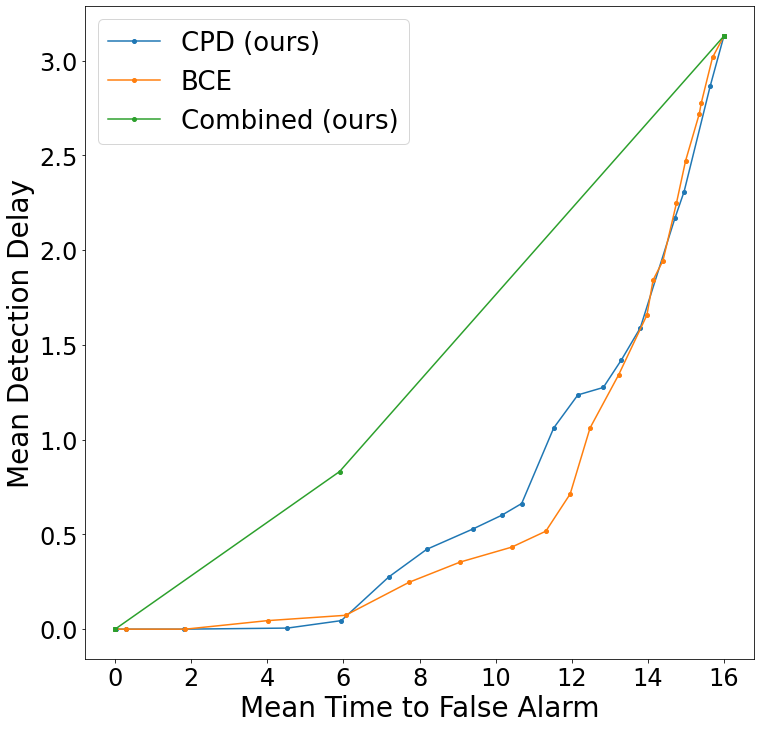

In [46]:
plt.figure(figsize=(12, 12))
plt.plot(fp_delay_list_cpd, delay_list_cpd, '-o', markersize=4, label='CPD (ours)')
plt.plot(fp_delay_list_bce, delay_list_bce, '-o', markersize=4, label='BCE')
plt.plot(fp_delay_list_combined, delay_list_combined, '-o', markersize=4, label='Combined (ours)')

plt.xlabel('Mean Time to False Alarm', fontsize=28)
plt.ylabel('Mean Detection Delay', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(loc='upper left', fontsize=26);